In [6]:
%pylab inline
import numpy as np
import yaml
from scipy.interpolate import interp1d
from scipy.optimize import leastsq

Populating the interactive namespace from numpy and matplotlib


In [76]:

def load_yaml(fname):
    with open(fname, 'r') as file:
        data = yaml.safe_load(file)
    return data

def compute_normalized_force_response(device_force_values, MVC, forceRangeMin=0.05, forceRangeMax=0.30, clamp=None):
    """
    Convert from sensor values to heigt values that were used in the display for direct comparison to the target sequence. Works fine for any array.
    ((deviceForceValue / MVC) - forceRangeMin)/(forceRangeMax-forceRangeMin)

    MVC:            maximumum voluntary contraction of this individual (in original device units)
    clamp:          list of min/max values to clamp any values that are above or below to, default = None (no clamping)
    """

    norm_resp = ((device_force_values / MVC) - forceRangeMin)/(forceRangeMax-forceRangeMin)
    if clamp is not None:
        norm_resp[norm_resp<clamp[0]] = clamp[0]
        norm_resp[norm_resp>clamp[1]] = clamp[1]
    return norm_resp

def lag_calc(yy,yy_shifted):
    """
    Calculate lag, in discrete samples. I.e., max resolution is one sample (1/freq)
    """
    #easy way, with max res of 1 unit of time
    #returns positive value for lag (i.e., yy_shifted occurs after yy in time)
    from scipy import signal
    
    xcorr = signal.correlate(yy,yy_shifted,mode='full')
    lags = signal.correlation_lags(yy.size,yy_shifted.size,mode='full')
    lag = lags[np.argmax(xcorr)]
    return lag*-1

def lag_calc_ms(for_time,ref_vals_interp,for_vals,initial_guess=0):
    """
    Based on least squares version, but turns out to be less accurate in some cases due to requirement to fill
    initial_guess = 0 is a zero time lag
    """
    # # compute temporal lag
    def err_func(p): #we fill data at the ends with the last value recorded for that trial (and first with first)
        # return interp1d(for_time,ref_vals_interp,kind='cubic',fill_value="extrapolate")(for_time[1:-1]+p[0]) - for_vals[1:-1]
        return interp1d(for_time,ref_vals_interp,kind='cubic',bounds_error=False,fill_value=(for_vals[0],for_vals[-1]))(for_time[1:-1]+p[0]) - for_vals[1:-1]
        # return interp1d(for_time,ref_vals_interp,kind='cubic',bounds_error=False,fill_value=np.mean(for_vals))(for_time[1:-1]+p[0]) - for_vals[1:-1]
    p0 = [initial_guess,] # Inital guess: 0 = no shift
    found_shift = leastsq(err_func,p0)[0][0]
    return found_shift*-1 #positive values are greater lag (i.e., response after reference)

def get_trial_type_from_name(trial_name, trial_type_keys):
    """
    Helper function to return the trial type from given trial_name and set of all possible types
    """
    trial_key_idx = []    
    for idx,trial_name_key in enumerate(trial_type_keys):
        if trial_name_key in trial_name:
            trial_key_idx.append(idx)
    if len(trial_key_idx)>1:
        print('The trial names set in your config file were not uniquely identifiable')
        print('Exiting --------------------------------------------------------------')
        return 'XXX_ERROR_XXX'
    else:
        return trial_type_keys[trial_key_idx[0]]

def score_spft_data(data,for_resp,description = "e.g., right hand performance", 
                    reference_designation='leftReference', trial_type_keys = ['LRN','SMP','RST'],
                    exclude_meta_keys = ['blocks','devices']):
    """
    exclude_meta_keys:      dictionary keys to exclude from stored metadata
    """
    MVC = data['maximumLeftVoluntaryContraction']
    blocks = data['blocks']
    #all times and values from the device over the course of the experiment, stored as single vectors
    for_time_all = np.array(for_resp['times'])
    for_vals_all = compute_normalized_force_response(np.array(for_resp['values']),MVC) #convert to normalized value for comparison

    all_lag_xcorr_ms = []
    all_lag_lstsq_ms = []
    all_raw_rmse = []
    all_raw_sse = []
    all_rmse = []
    all_sse = []

    res = {} #results dictionary
    for key in data.keys():
        if not (key in exclude_meta_keys):
            res[key] = data[key]
    res['reference_designation'] = reference_designation #L or R reference bar
    res['description'] = description
    res['all'] = {}
    for trial_type in trial_type_keys:
        res['all'][trial_type] = {}
        res['all'][trial_type]['lag_xcorr_ms'] = []
        res['all'][trial_type]['lag_lstsq_ms'] = []
        res['all'][trial_type]['raw_rmse'] = []
        res['all'][trial_type]['raw_sse'] = []
        res['all'][trial_type]['rmse'] = []
        res['all'][trial_type]['sse'] = []

    for block_idx in np.arange(len(blocks)):
        res[f'block_{block_idx}'] = {}
        for trial_type in trial_type_keys:
            res[f'block_{block_idx}'][trial_type] = {}
            res[f'block_{block_idx}'][trial_type]['lag_xcorr_ms'] = []
            res[f'block_{block_idx}'][trial_type]['lag_lstsq_ms'] = []
            res[f'block_{block_idx}'][trial_type]['raw_rmse'] = []
            res[f'block_{block_idx}'][trial_type]['raw_sse'] = []
            res[f'block_{block_idx}'][trial_type]['rmse'] = []
            res[f'block_{block_idx}'][trial_type]['sse'] = []

        for trial_idx in np.arange(len(blocks[block_idx]['trials'])):
            trial_name = blocks[block_idx]['trials'][trial_idx]['trialName']
            trial_type = get_trial_type_from_name(trial_name,trial_type_keys)
            ref_time = np.array(blocks[block_idx]['trials'][trial_idx][reference_designation]['times'])
            ref_vals = np.array(blocks[block_idx]['trials'][trial_idx][reference_designation]['values'])

            start = ref_time[0]
            end = ref_time[-1]
            # print(end-start)

            # compute mask of data in for response vector associated with this specific trial, select time/vals
            for_trial_mask = (for_time_all-start >= 0) & (for_time_all-end+1000<=0) 
            for_time = for_time_all[for_trial_mask]
            for_vals = for_vals_all[for_trial_mask]

            # bring ref vals into the same time space by interpolating, for direct comparison
            # then compute lag and other metrics, also shift by lag and compute metrics again
            # times are in ms, and we use the median time per interval for the conversion of lag (in timestep units) to ms
            ref_vals_interp = np.interp(for_time,ref_time,ref_vals) #linear (piece-wise) interpolation of presented target bar positions into the actual response, now we can subtract directly
            # ref_vals_interp = interp1d(ref_time,ref_vals,kind='cubic')(for_time) #does not seem to make a difference here
            trial_lag_xcorr = lag_calc(ref_vals_interp,for_vals) #in samples
            time_per_interval = np.median(np.diff(for_time)) #time, in ms
            time_std_per_interval = np.std(np.diff(for_time)) #time, in ms
            trial_lag_xcorr_ms = trial_lag_xcorr*time_per_interval
            for_time = for_time - for_time[0] #zero time so that our plots start at 0
            trial_lag_ms = lag_calc_ms(for_time,ref_vals_interp,for_vals) #alternative way, not sure if this is correct in the end
            # print(trial_lag_ms)
            
            # raw RMSE and SSE
            trial_rmse = np.sqrt(np.mean((ref_vals_interp-for_vals)**2)) #root mean squared error
            trial_sse = ((ref_vals_interp-for_vals)**2).sum()


            # we now take the aligned vectors, snip the parts that we do not have data for, and compare to compute our lag-aligned version
            if trial_lag_xcorr >0: #we have a lag (i.e., the force comes after the reference)
                snipped_for_vals = for_vals[trial_lag_xcorr:]
                snipped_ref_vals = ref_vals_interp[0:trial_lag_xcorr*-1]
                snipped_for_time = for_time[trial_lag_xcorr:]
            elif trial_lag_xcorr <0: #force preceded the reference
                snipped_for_vals = for_vals[0:trial_lag_xcorr*-1]
                snipped_ref_vals = ref_vals_interp[trial_lag_xcorr:]
                snipped_for_time = for_time[0:trial_lag_xcorr*-1]
            elif trial_lag_xcorr == 0:
                snipped_for_vals = for_vals
                snipped_ref_vals = ref_vals_interp
                snipped_for_time = for_time

            # proportion of elements used to compute RMSE and SSE
            trial_prop_good_els = snipped_for_vals.shape[0] / for_vals.shape[0] 
            # lag-algined RMSE and SSE
            lag_aligned_trial_rmse = np.sqrt(np.mean((snipped_ref_vals-snipped_for_vals)**2)) #root mean squared error #TOOD: have someone confirm algo
            lag_aligned_trial_sse = ((snipped_ref_vals-snipped_for_vals)**2).sum()
            
            # print(f'Block {block_idx} - Trial {trial_idx}')
            # print(f'median interval time: {time_per_interval:.2f} ms')
            # print(f'std interval time   : {time_std_per_interval:.2f} ms')
            # print(f'lag (time steps)    : {trial_lag_xcorr}')
            # print(f'lag                 : {trial_lag_xcorr_ms:.2f} ms')
            # print(f'lag (lstsq)         : {trial_lag_ms:.2f}')
            # print(f'rmse                : {trial_rmse:.2f} ms')
            # print(f'sse                 : {trial_sse:.2f} ms')
            # print(f'lag-aligned rmse    : {lag_aligned_trial_rmse:.2f} ms')
            # print(f'lag-aligned sse     : {lag_aligned_trial_sse:.2f} ms')
            # print(f'prop good elelements: {trial_prop_good_els:.2f}')
            # print("")
            
            # print(np.corrcoef(snipped_for_vals,snipped_ref_vals)[0,1])
            # print(np.corrcoef(ref_vals_interp,np.interp(for_time+trial_lag_ms, for_time,for_vals))[0,1])
            
            #block-wise data
            res[f'block_{block_idx}'][trial_type]['lag_xcorr_ms'].append(trial_lag_xcorr_ms)
            res[f'block_{block_idx}'][trial_type]['lag_lstsq_ms'].append(trial_lag_ms)
            res[f'block_{block_idx}'][trial_type]['raw_rmse'].append(trial_rmse)
            res[f'block_{block_idx}'][trial_type]['raw_sse'].append(trial_sse)
            res[f'block_{block_idx}'][trial_type]['rmse'].append(lag_aligned_trial_rmse)
            res[f'block_{block_idx}'][trial_type]['sse'].append(lag_aligned_trial_sse)
            
            #all data concatenated
            res['all'][trial_type]['lag_xcorr_ms'].append(trial_lag_xcorr_ms)
            res['all'][trial_type]['lag_lstsq_ms'].append(trial_lag_ms)
            res['all'][trial_type]['raw_rmse'].append(trial_rmse)
            res['all'][trial_type]['raw_sse'].append(trial_sse)
            res['all'][trial_type]['rmse'].append(lag_aligned_trial_rmse)
            res['all'][trial_type]['sse'].append(lag_aligned_trial_sse)
        
        #convert the current block results to numpy arrays
        res[f'block_{block_idx}'][trial_type]['lag_xcorr_ms'] = np.array(res[f'block_{block_idx}'][trial_type]['lag_xcorr_ms'])
        res[f'block_{block_idx}'][trial_type]['lag_lstsq_ms'] = np.array(res[f'block_{block_idx}'][trial_type]['lag_lstsq_ms'])
        res[f'block_{block_idx}'][trial_type]['raw_rmse'] = np.array(res[f'block_{block_idx}'][trial_type]['raw_rmse'])
        res[f'block_{block_idx}'][trial_type]['raw_sse'] = np.array(res[f'block_{block_idx}'][trial_type]['raw_sse'])
        res[f'block_{block_idx}'][trial_type]['rmse'] = np.array(res[f'block_{block_idx}'][trial_type]['rmse'])
        res[f'block_{block_idx}'][trial_type]['sse'] = np.array(res[f'block_{block_idx}'][trial_type]['sse'])
            
            # plt.figure()
            # plt.plot(for_time,ref_vals_interp,'k-',label='reference')
            # plt.plot(for_time,for_vals,'b-',alpha=0.5, label='force')
            # # plt.plot(snipped_for_time,snipped_ref_vals,'k-',label='reference')
            # plt.plot(snipped_for_time-trial_lag_xcorr_ms,snipped_for_vals,'r:',label='aligned force')
            # plt.plot(snipped_for_time-trial_lag_ms,snipped_for_vals,'g:',label='aligned force')
            
            # # plt.text(f'lag {trial_lag_xcorr_ms:.2f} ms')
            # plt.legend()
        #     print(np.corrcoef(snipped_for_vals, snipped_ref_vals)[0,1])
        #     print(trial_lag_xcorr)
        #     print(np.corrcoef(snipped_for_vals[first_match_idx:], snipped_ref_vals[first_match_idx:])[0,1])
        #     if trial_idx ==1:
        #         break

    #convert summary results in 'all' to numpy arrays
    res['all'][trial_type]['lag_xcorr_ms'] = np.array(res['all'][trial_type]['lag_xcorr_ms'])
    res['all'][trial_type]['lag_lstsq_ms'] = np.array(res['all'][trial_type]['lag_lstsq_ms'])
    res['all'][trial_type]['raw_rmse'] = np.array(res['all'][trial_type]['raw_rmse'])
    res['all'][trial_type]['raw_sse'] = np.array(res['all'][trial_type]['raw_sse'])
    res['all'][trial_type]['rmse'] = np.array(res['all'][trial_type]['rmse'])
    res['all'][trial_type]['sse'] = np.array(res['all'][trial_type]['sse'])
        
    return res

In [71]:
#load the yaml data, assign block presentation data and device response data
data = load_yaml('./testing/Isa3_Test_Right_Only_out-file.txt')
blocks = data['blocks']
device_idx = 0
for_resp = data['devices'][device_idx]
data.keys()

dict_keys(['sessionName', 'startTime', 'configurationFile', 'configurationChecksum', 'participantId', 'maximumLeftVoluntaryContraction', 'blocks', 'devices', 'triggers'])

In [72]:

trial_name_keys = ['LRN','SMP','RST']
trial_name = blocks[0]['trials'][0]['trialName']

get_trial_name(trial_name, trial_name_keys)


'LRN'

In [77]:
res = score_spft_data(data,for_resp)
res['block_0']['LRN']
res['all']['LRN']

{'lag_xcorr_ms': array([179.10000086, 155.09000087,  11.93000007, 167.15999913,
         83.4399997 , 107.36999953]),
 'lag_lstsq_ms': array([186.44174009, 221.56072988, 167.68695811, 181.72249502,
        159.87111656, 182.18882936]),
 'raw_rmse': array([0.16097489, 0.19028802, 0.19996889, 0.16049545, 0.16487721,
        0.1479426 ]),
 'raw_sse': array([49.8823598 , 70.02922972, 76.65614733, 49.86901435, 52.22141226,
        42.00117586]),
 'rmse': array([0.12288733, 0.16698566, 0.19894812, 0.12164614, 0.15288188,
        0.12988215]),
 'sse': array([28.84347403, 53.56556581, 75.83595801, 28.4413403 , 44.73567032,
        32.22050301])}

In [78]:
res.keys()

dict_keys(['sessionName', 'startTime', 'configurationFile', 'configurationChecksum', 'participantId', 'maximumLeftVoluntaryContraction', 'triggers', 'reference_designation', 'description', 'all', 'block_0', 'block_1'])

In [282]:
print(np.corrcoef(ref_vals_interp,np.interp(for_time+trial_lag_ms, for_time,for_vals))[0,1])
print(np.corrcoef(snipped_for_vals,snipped_ref_vals)[0,1])

0.7893307472790471
0.771862538169145


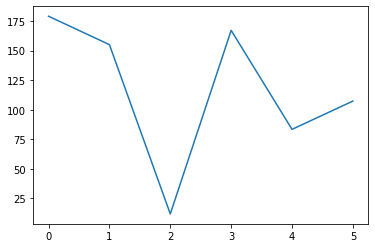

In [305]:
plt.plot(res['all']['lag_xcorr_ms'])

array([[1.        , 0.99756188],
       [0.99756188, 1.        ]])

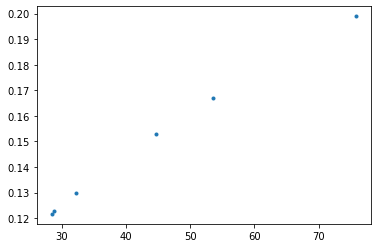

In [289]:
# plt.plot(raw_sse,sse,'.')
plt.plot(sse,rmse,'.')
np.corrcoef(sse,rmse)

array([[1.        , 0.59404239],
       [0.59404239, 1.        ]])

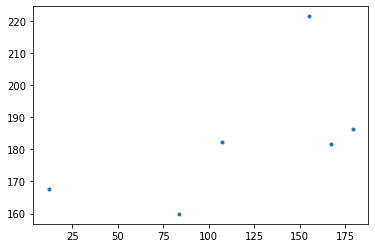

In [283]:
plt.plot(lag_xcorr_ms,lag_lstsq_ms,'.')
np.corrcoef(lag_xcorr_ms,lag_lstsq_ms)

0.0
22599.41000008583


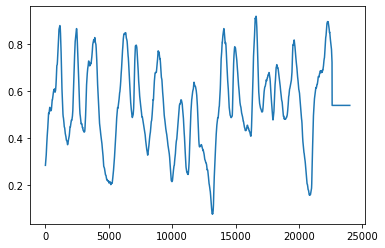

In [237]:
ff = interp1d(for_time,for_vals,kind='cubic',bounds_error=False,fill_value=np.mean(for_vals))
print(np.min(for_time))
print(np.max(for_time))

plt.plot(np.arange(0,24000,1),ff(np.arange(0,24000,1)))

(14000.0, 20000.0)

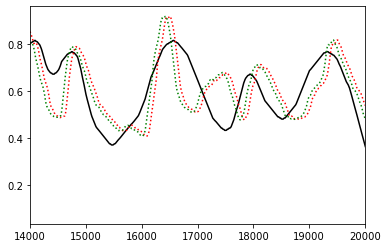

In [246]:
plt.figure()
plt.plot(for_time,ref_vals_interp,'k-',label='reference')
# plt.plot(for_time,for_vals,'b-',alpha=0.5, label='force')
# plt.plot(snipped_for_time,snipped_ref_vals,'k-',label='reference')
plt.plot(snipped_for_time-trial_lag_xcorr_ms,snipped_for_vals,'r:',label='aligned force')
plt.plot(snipped_for_time-trial_lag_ms,snipped_for_vals,'g:',label='aligned force')
plt.xlim(14000,20000)
# plt.ylim(0.6,1)

In [109]:
lag_calc_ms(for_time,ref_vals_interp,for_vals)

-82.44301786770032

In [63]:
ref_vals_interp.shape
snipped_ref_vals.shape
snipped_for_time

array([5.87298412e+08, 5.87298423e+08, 5.87298435e+08, ...,
       5.87321874e+08, 5.87321887e+08, 5.87321898e+08])

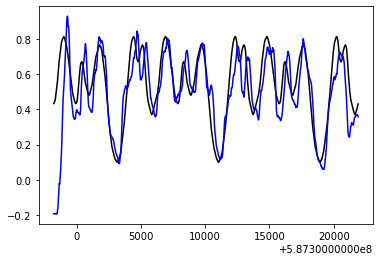

In [45]:
plt.figure()
plt.plot(for_time,ref_vals_interp,'k-',label='reference')
plt.plot(for_time,for_vals,'b-',label='force')
# plt.plot(snipped_for_time,snipped_for_vals,'r-',label='aligned force')

(1995,)
(1995,)


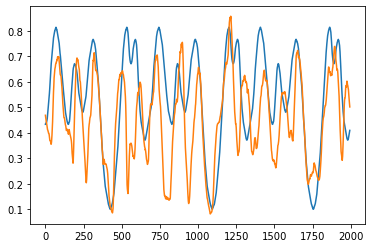

In [18]:


print(snipped_for_vals.shape)
print(snipped_ref_vals.shape)

plt.plot(snipped_ref_vals)
plt.plot(snipped_for_vals)
# for_vals.shape

[0]
[0.]
[0.]
[1.49011612e-08]
[-121.98935654]
[-121.98935472]
[-74.69475903]
[-74.69475792]
[-91.71327781]
[-91.71327781]
[-91.71327781]
[-82.10358687]
[-82.10358565]
[-82.81225896]
[-82.81225896]
[-82.81225896]
[-82.81225896]
[-82.4867231]
[-82.48672187]
[-82.40283754]
[-82.40283754]
[-82.40283754]
[-82.44301787]
[-82.44301664]
[-82.44928763]
-82.44301786770032
16


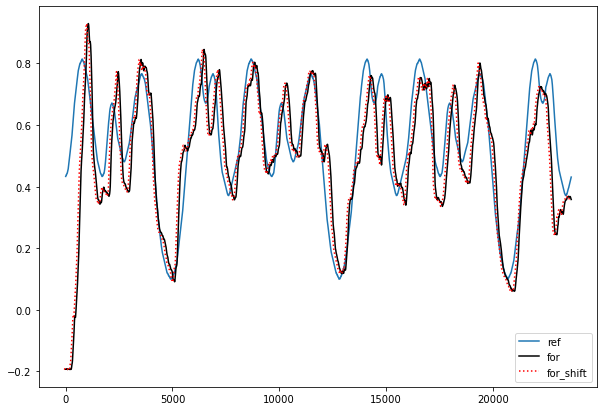

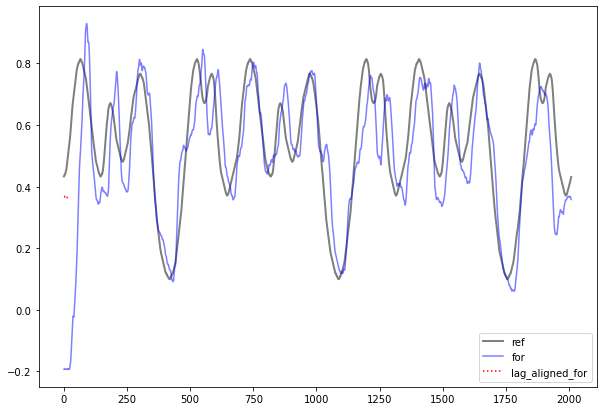

In [72]:
#bring the reference positions into the same time space as the force for direct comparison (linear interp)
# ref_vals_interp = np.interp(for_time,ref_time,ref_vals) #linear (piece-wise) interpolation of presented target bar positions into the actual response, now we can subtract directly

# # compute temporal lag
def err_func(p):
    print(p)
    return interp1d(for_time,ref_vals_interp,kind='cubic',fill_value="extrapolate")(for_time[1:-1]+p[0]) - for_vals[1:-1]

p0 = [0,] # Inital guess of no shift
found_shift = leastsq(err_func,p0)[0][0]
lag_xcorr = lag_calc(ref_vals_interp,for_vals)
print(found_shift)
print(lag_xcorr)

# lstsq approach
plt.figure(figsize=(10,7))
# plt.plot(ref_time,ref_vals,'.',label='ref_orig')
plt.plot(for_time,ref_vals_interp,label='ref')
plt.plot(for_time,for_vals,'k-',label='for')
plt.plot(for_time+found_shift,for_vals,'r:',label='for_shift')
plt.legend()

plt.figure(figsize=(10,7)) #xcorr approach
plt.plot(ref_vals_interp,'k-',linewidth=2,label='ref',alpha=0.5)
plt.plot(for_vals,'b-',label='for',alpha=0.5)
plt.plot(for_vals[lag_xcorr*-1:],'r:',label='lag_aligned_for')
plt.legend()